# Importing Libraries

In [1]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPool2D, Input, Flatten

# Setting up GPU Growth

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Creating folders

In [ ]:
os.makedirs(os.path.join('data','positive'))
os.makedirs(os.path.join('data','negative'))
os.makedirs(os.path.join('data','anchors'))

# Collecting Data

## 1.Negative faces data

### Downloaded Dataset from internet

In [ ]:
for dirs in os.listdir("lfw"):
    for file in os.listdir("lfw/" + dirs):
        prev = os.path.join('lfw', dirs, file)
        new = os.path.join('data', 'negative', file)
        os.replace(prev, new)

## 2. Collecting Positive and Anchor Classes

In [ ]:
import uuid  # generate unique image names

In [ ]:
# using webcam for collecting positive and anchor dataset
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
# xs = []
# ys = []
# i = 0
while cap.isOpened():
    ret, frame = cap.read()
    # cut down shape to 250x250
    frame = frame[120:370,200:450,:]  
    cv2.imshow('frame', frame)

    # capturing anchor images
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = "./data/anchors/{}.jpg".format(uuid.uuid1())
        cv2.imwrite(imgname, frame)
    # capturing positive images
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = "./data/positive/{}.jpg".format(uuid.uuid1())
        cv2.imwrite(imgname, frame)    
    # i+=1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Loading and Preprocessing data

## 1.Loading data

In [3]:
anchor = tf.data.Dataset.list_files("./data/anchors"+'/*.jpg').take(340)
positive = tf.data.Dataset.list_files("./data/positive"+'/*.jpg').take(340)
negative = tf.data.Dataset.list_files("./data/negative"+'/*.jpg').take(340)

## 2.Preprocessing - Scaling and Resizing

In [4]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)  # reading image
    img = tf.io.decode_jpeg(byte_img)      # decoding and loading 
    # preprocessing, resizing
    img = tf.image.resize(img, (100,100))  
    img= img/255.0
    return img

## 3.Creating Labelled Dataset

In [5]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [7]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

## 4.Building Train and Test Partition

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [9]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [10]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [11]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

#  Siamese Neural Network

## Building Embedding layer

In [17]:
def Embedding_layer(input_shape=(100,100,3)):
    inp = Input(shape=input_shape, name="input_image")
    # first block
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    m1 = MaxPool2D(64,(2,2), padding='same')(c1)

    # second block
    c2 = Conv2D(128,(7,7), activation='relu')(m1)
    m2 = MaxPool2D(64,(2,2), padding='same')(c2)

    # third block
    c3 = Conv2D(128,(4,4), activation='relu')(m2)
    m3 = MaxPool2D(64,(2,2), padding='same')(c3)

    # fourth block
    c4 = Conv2D(256,(4,4), activation='relu')(m3)

    # flatten
    fc = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(fc)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

## Building Distance Layer

In [18]:
class L1dist(Layer):
    def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable=trainable, name=name, dtype=dtype, dynamic=dynamic, **kwargs)

    def call(self, input_embedding, val_embedding):
        return tf.math.abs(input_embedding - val_embedding)

In [19]:
embedding = Embedding_layer()

## Making Siamese Model

In [20]:
def Siamese_model():
    # Inputs
    input_img = Input(name='input_img', shape=(100,100,3))
    val_img = Input(name='val_img', shape=(100,100,3))

    # Embeddings
    siamese_layer = L1dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img), embedding(val_img))
    
    # Classification Layer
    classify = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_img, val_img], outputs=classify, name='Siamese_Network')

siamese_model = Siamese_model()

In [43]:
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
val_img (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 val_img[0][0]                    
__________________________________________________________________________________________________
distance (L1dist)               (None, 4096)         0           embedding[4][0]    

# Training

## 1.Loss Function and Optimizer

In [12]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(0.0001)

## 2. Setup Checkpoints

In [45]:
ckpt_dir = './training_checkpts'
ckpt_prefix = './training_checkpts/ckpt'
ckpt = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 3.Train Step Function

In [46]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)  # forward pass
        loss = binary_cross_loss(y, yhat)   # loss
        
    print(loss)
    # calculating gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))

    return loss

## 4.Training Loop

In [47]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
             train_step(batch)
             progbar.update(idx+1)
        
        #Save Checkpoint
        if epoch % 10 == 0:
            ckpt.save(file_prefix=ckpt_prefix)

## 5. Training the Model

In [48]:
EPOCHS = 50

In [49]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
30/30 [==============================] - 15s 490ms/step

 Epoch 2/50
30/30 [==============================] - 14s 473ms/step

 Epoch 3/50
30/30 [==============================] - 14s 475ms/step

 Epoch 4/50
30/30 [==============================] - 14s 476ms/step

 Epoch 5/50
30/30 [==============================] - 14s 477ms/step

 Epoch 6/50
30/30 [==============================] - 14s 477ms/step

 Epoch 7/50
30/30 [==============================] - 14s 476ms/step

 Epoch 8/50
30/30 [==============================] - 14s 478ms/step

 Epoch 9/50
30/30 [==============================] - 14s 475ms/step

 Epoch 10/50
30/30 [==============================] - 14s 471ms/step

 Epoch 11/50
30/30 [==============================] - 14s 476ms/step

 Epoch 12/50
30/30 [==============================] - 14s 471ms/step

 Epoch 13/50
3

# Evaluating Model

## Making Predictions and Using Metrics

In [13]:
from tensorflow.keras.metrics import Precision, Recall

In [14]:
test_input, test_val, y_rue = test_data.as_numpy_iterator().next()

In [15]:
predictions = siamese_model.predict([test_input, test_val])
predictions

NameError: name 'siamese_model' is not defined

In [79]:
y_hat = predictions

In [80]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]

In [81]:
y_true = y_rue
y_true

array([0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [82]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

## Viz Results

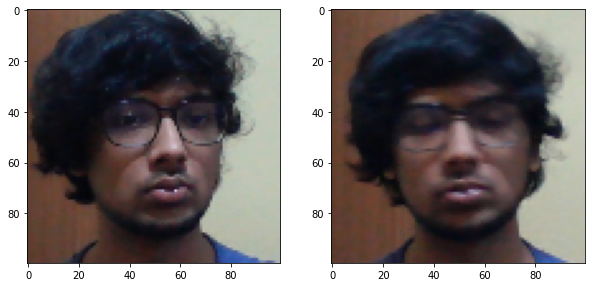

In [84]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()

# Save Model

In [85]:
siamese_model.save('siamesemodel.h5')

In [21]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                    custom_objects={'L1dist':L1dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [22]:
model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
val_img (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 val_img[0][0]                    
__________________________________________________________________________________________________
distance (L1dist)               (None, 4096)         0           embedding[0][0]    

# Real Time Test

## Verification Function

In [27]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir("./application_data/verification_images"):
        input_img = preprocess("./application_data/input_image/input_image.jpg")
        validation_img = preprocess("./application_data/verification_images/"+image)
        pred = model.predict(list(np.expand_dims([input_img, validation_img],axis=1)))
        results.append(pred)
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(results) 
    verified = verification > verification_threshold

    return results, verified

## OpenCV Detection

In [36]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:370,200:450,:]  
    cv2.imshow('Verification', frame)
    # Verify
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save input_image 
        cv2.imwrite("./application_data/input_image/input_image.jpg", frame)
        # verification
        results, verified = verify(model, 0.6,0.7)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
False


In [33]:
np.sum(np.squeeze(results) > 0.5)

28

In [34]:
28/50

0.56